In [1]:
import datetime
import pandas as pd
import numpy as np
from difflib import SequenceMatcher
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

In [2]:
# Change figure plot size
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
# Import CSV data
money = r'C:\Users\xrchr\SynologyDrive\Desktop\Coding\Python\Projects\6_Money_Completed\DataSource\Mint_Transactions.csv'

# Read Data
mint = pd.read_csv(money)
mint.head()

,Date,Description,Original Description,Amount,Transaction Type,Category,Account Name,Labels,Notes
0,11/1/2019,ONLINE TRANSFER TO SAV ...9227 TRANSACTION#: 8...,ONLINE TRANSFER TO SAV ...9227,75.00,debit,Transfer,CHASE COLLEGE,NaN,NaN
1,11/1/2019,T-Mobile,TMOBILE*AUTO PAY,95.41,debit,Mobile Phone,CREDIT CARD,NaN,NaN
2,11/1/2019,ONLINE TRANSFER FROM CHK ...732 5 TRANSACTION#...,ONLINE TRANSFER FROM CHK ...732,75.00,credit,Transfer,CHASE SAVINGS,NaN,NaN
3,11/1/2019,ORIG CO NAME:NORTHROP GRUMMAN CO ENTRY DESCR:D...,ORIG CO NAME:NORTHROP GRUMMAN CO,2761.12,credit,Paycheck,CHASE COLLEGE,NaN,NaN
4,10/31/2019,Food 4 Less,FOOD4LESS 0313,90.53,debit,Groceries,CREDIT CARD,NaN,NaN


In [4]:
# Separate Accounts into most frequently used (core) and accounts used for savings (invest_savings)
core = mint[mint['Account Name'].str.lower().str.contains("college|discover|credit")].copy()
# core.is_copy = False
invest_savings = mint[mint['Account Name'].str.lower().str.contains("savings")].copy()
# invest_savings.is_copy = False
#invest_savings['Account Name'].unique()

In [5]:
# Remove Labels and Notes column
core = core.drop(labels=['Labels', 'Notes'], axis=1)
core.head()

,Date,Description,Original Description,Amount,Transaction Type,Category,Account Name
0,11/1/2019,ONLINE TRANSFER TO SAV ...9227 TRANSACTION#: 8...,ONLINE TRANSFER TO SAV ...9227,75.00,debit,Transfer,CHASE COLLEGE
1,11/1/2019,T-Mobile,TMOBILE*AUTO PAY,95.41,debit,Mobile Phone,CREDIT CARD
3,11/1/2019,ORIG CO NAME:NORTHROP GRUMMAN CO ENTRY DESCR:D...,ORIG CO NAME:NORTHROP GRUMMAN CO,2761.12,credit,Paycheck,CHASE COLLEGE
4,10/31/2019,Food 4 Less,FOOD4LESS 0313,90.53,debit,Groceries,CREDIT CARD
5,10/31/2019,TRANSFER TO SAV 10/31,TRANSFER TO SAV XXXXX9227 10/31,25.00,debit,Transfer,CHASE COLLEGE


In [6]:
# Investigate what transactions need to be removed
chase = core[core['Account Name'].str.lower().str.contains('college')]
discover = core[core['Account Name'].str.lower().str.contains('discover')]
chase_cred = chase[chase['Transaction Type'] == 'debit']
chase_cred['Category'].unique()

array(['Transfer', 'Mortgage & Rent', 'Credit Card Payment', 'Utilities',
       'Bills & Utilities', 'Auto & Transport', 'Amusement', 'Groceries',
       'Shopping', 'Restaurants', 'Sports', 'Laundry', 'Auto Payment',
       'Cash & ATM', 'Fees & Charges', 'Food & Dining', 'Parking',
       'Gas & Fuel', 'Auto Insurance', 'Financial', 'Investments',
       'Financial Advisor', 'Charity', 'Rental Car & Taxi', 'Fast Food',
       'Air Travel', 'Entertainment', 'Bank Fee', 'ATM Fee',
       'Movies & DVDs', 'Books'], dtype=object)

In [7]:
# saving = mint2[mint2['Account Name'].str.lower().str.contains('online savings')]
# cfna = mint2[mint2['Account Name'].str.lower().str.contains('cfna')]
# core[core['Category'] == 'Investments']

In [8]:
# Define Conditions for rows to be removed
# This includes paying off credit cards, transferring to saving account or checking account
ccp = ['Internet Thank You', 'Directpay Full Balance', 'Transfer from CHASE COLLEGE', 'Cashback Bonus Redemption', 
       'Reward Statement', 'Directpay Full Balancesee']
Financial = ['Buy', 'Investments', 'Financial', 'Financial Advisor', 'Finance Charge']
# Remove credit card payments
cond = core[(core['Account Name'] == 'Discover it chrome Card') & (core['Description'].str.contains("|".join(ccp)))]
cond2 = core[(core['Account Name'] == 'CHASE COLLEGE') & (core['Description'].str.lower().str.contains('discover'))]
cond3 = core[(core['Account Name'] == 'CHASE COLLEGE') & (core['Original Description'].str.contains('SAV'))]
cond4 = core[(core['Account Name'] == 'CHASE COLLEGE') & (core['Category'].str.contains("|".join(Financial)))]
# cond4 = mint2[(mint2['Account Name'] == 'CHASE SAVINGS') & (mint2['Original Description'].str.contains('CHK'))]
# cond5 = mint2[mint2['Account Name'].str.lower().contains('cfna')]

In [9]:
# Drop all the rows that meet the conditions specified
core.drop(cond.index, inplace=True)
core.drop(cond2.index, inplace=True)
core.drop(cond3.index, inplace=True)
core.drop(cond4.index, inplace=True)
core.head()

,Date,Description,Original Description,Amount,Transaction Type,Category,Account Name
1,11/1/2019,T-Mobile,TMOBILE*AUTO PAY,95.41,debit,Mobile Phone,CREDIT CARD
3,11/1/2019,ORIG CO NAME:NORTHROP GRUMMAN CO ENTRY DESCR:D...,ORIG CO NAME:NORTHROP GRUMMAN CO,2761.12,credit,Paycheck,CHASE COLLEGE
4,10/31/2019,Food 4 Less,FOOD4LESS 0313,90.53,debit,Groceries,CREDIT CARD
9,10/30/2019,Northrop Grumman Eft,NORTHROP GRUMMAN EFT PMT,89.90,credit,Income,CHASE COLLEGE
10,10/30/2019,76 - P&J GAS,76 - P&J GAS,46.08,debit,Gas & Fuel,CREDIT CARD


In [10]:
# set the datetimeindex
core['Date'] = pd.to_datetime(core['Date'])

core.head()

,Date,Description,Original Description,Amount,Transaction Type,Category,Account Name
1,2019-11-01,T-Mobile,TMOBILE*AUTO PAY,95.41,debit,Mobile Phone,CREDIT CARD
3,2019-11-01,ORIG CO NAME:NORTHROP GRUMMAN CO ENTRY DESCR:D...,ORIG CO NAME:NORTHROP GRUMMAN CO,2761.12,credit,Paycheck,CHASE COLLEGE
4,2019-10-31,Food 4 Less,FOOD4LESS 0313,90.53,debit,Groceries,CREDIT CARD
9,2019-10-30,Northrop Grumman Eft,NORTHROP GRUMMAN EFT PMT,89.90,credit,Income,CHASE COLLEGE
10,2019-10-30,76 - P&J GAS,76 - P&J GAS,46.08,debit,Gas & Fuel,CREDIT CARD


In [11]:
# Add column for days between buying items
core['Freq-Desc'] = core.groupby(['Description'])['Date'].diff().dt.days
core['Freq-Desc'] = core['Freq-Desc'].replace(0.0, np.nan)
core = core.set_index('Date')
core.head()

,Description,Original Description,Amount,Transaction Type,Category,Account Name,Freq-Desc
Date,,,,,,,
2019-11-01,T-Mobile,TMOBILE*AUTO PAY,95.41,debit,Mobile Phone,CREDIT CARD,NaN
2019-11-01,ORIG CO NAME:NORTHROP GRUMMAN CO ENTRY DESCR:D...,ORIG CO NAME:NORTHROP GRUMMAN CO,2761.12,credit,Paycheck,CHASE COLLEGE,NaN
2019-10-31,Food 4 Less,FOOD4LESS 0313,90.53,debit,Groceries,CREDIT CARD,NaN
2019-10-30,Northrop Grumman Eft,NORTHROP GRUMMAN EFT PMT,89.90,credit,Income,CHASE COLLEGE,NaN
2019-10-30,76 - P&J GAS,76 - P&J GAS,46.08,debit,Gas & Fuel,CREDIT CARD,NaN


In [12]:
# Investigate categories
categories = core['Category'].unique()
categories

array(['Mobile Phone', 'Paycheck', 'Groceries', 'Income', 'Gas & Fuel',
       'Mortgage & Rent', 'Parking', 'Coffee Shops', 'Movies & DVDs',
       'Credit Card Payment', 'Food & Dining', 'Shopping', 'Restaurants',
       'Utilities', 'Gifts & Donations', 'Laundry', 'Bills & Utilities',
       'Rental Car & Taxi', 'Fast Food', 'Auto Insurance',
       'Entertainment', 'Service & Parts', 'Public Transportation',
       'Alcohol & Bars', 'Auto & Transport', 'Television',
       'Electronics & Software', 'Tuition', 'Amusement', 'Personal Care',
       'Sports', 'Hotel', 'Office Supplies', 'Eyecare', 'Air Travel',
       'Hobbies', 'Auto Payment', 'Clothing', 'Cash & ATM',
       'Fees & Charges', 'Federal Tax', 'Vacation', 'State Tax',
       'Spa & Massage', 'Pharmacy', 'Gift', 'Charity', 'Travel', 'Arts',
       'Home Insurance', 'Business Services', 'Shipping', 'Home Supplies',
       'Home Improvement', 'Home Services', 'Furnishings', 'Bank Fee',
       'Doctor', 'ATM Fee', 'Books', 

In [13]:
# # Cell for manipulating DataFrame
# core['Category'].loc[(core['Category'] == 'Toys')] =

In [14]:
# # Investigate certain categories:
# core[core['Category'] == 'Bonus']

In [15]:
# Create a higher category to make it easeir to organize
Food = ['Food & Dining', 'Restaurants', 'Fast Food', 'Groceries', 'Alcohol & Bars', 'Coffee Shops']
Bills = ['Mortgage & Rent', 'Utilities', 'Mobile Phone', 'Home Insurance', 'Auto Insurance', 'Bills & Utilities',
         'Auto & Transport', 'Auto Payment', 'Service & Parts', 'Laundry', 'Internet', 'Gas & Fuel', 'Insurance'] 
# Financial = ['Buy', 'Investments', 'Financial', 'Financial Advisor', 'Finance Charge']
Travel = ['Parking', 'Rental Car & Taxi', 'Air Travel', 'Hotel', 'Travel', 'Public Transportation']
Fun = ['Movies & DVDs', 'Gift', 'Entertainment', 'Arts', 'Sports', 'Amusement']
Income = ['State Tax', 'Income', 'Interest Income', 'Paycheck', 'Federal Tax']
Shopping = ['Pharmacy', 'Shopping', 'Clothing', 'Electronics & Software', 'Business Services', 'Shipping',
            'Home Supplies', 'Home Improvement', 'Furnishings', 'Personal Care', 'Hobbies', 'Books', 'Music',
            'Office Supplies', 'Sporting Goods']
Misc = ['Charity', 'Cash & ATM', 'Bank Fee', 'Doctor', 'Auto & Transport', 'ATM Fee', 'Printing', 'Dentist', 
        'Student Loans', 'Education', 'Uncategorized', 'Health & Fitness', 'Pet Food & Supplies', 'Home Services']
# Other = ['Transfer', 'Bonus']

In [16]:
# Create empty column
core['Category2'] = ""
# Add Overall Category (Category2) based on Category
core['Category2'].loc[core['Category'].str.contains("|".join(Food))] = 'Food'
core['Category2'].loc[core['Category'].str.contains("|".join(Bills))] = 'Bills'
# core['Category2'].loc[core['Category'].str.contains("|".join(Financial))] = 'Financial'
core['Category2'].loc[core['Category'].str.contains("|".join(Travel))] = 'Travel'
core['Category2'].loc[core['Category'].str.contains("|".join(Fun))] = 'Fun'
core['Category2'].loc[core['Category'].str.contains("|".join(Income))] = 'Income'
core['Category2'].loc[core['Category'].str.contains("|".join(Shopping))] = 'Shopping'
core['Category2'].loc[core['Category'].str.contains("|".join(Misc))] = 'Misc'
# Leftover categories get added to Miscellaneous
core['Category2'].loc[core['Category2'] == ""] = 'Misc'
core.head()

C:\Users\xrchr\Miniconda3\envs\minimal_ds\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Description,Original Description,Amount,Transaction Type,Category,Account Name,Freq-Desc,Category2
Date,,,,,,,,
2019-11-01,T-Mobile,TMOBILE*AUTO PAY,95.41,debit,Mobile Phone,CREDIT CARD,NaN,Bills
2019-11-01,ORIG CO NAME:NORTHROP GRUMMAN CO ENTRY DESCR:D...,ORIG CO NAME:NORTHROP GRUMMAN CO,2761.12,credit,Paycheck,CHASE COLLEGE,NaN,Income
2019-10-31,Food 4 Less,FOOD4LESS 0313,90.53,debit,Groceries,CREDIT CARD,NaN,Food
2019-10-30,Northrop Grumman Eft,NORTHROP GRUMMAN EFT PMT,89.90,credit,Income,CHASE COLLEGE,NaN,Income
2019-10-30,76 - P&J GAS,76 - P&J GAS,46.08,debit,Gas & Fuel,CREDIT CARD,NaN,Bills


In [17]:
core[core['Category2'] == ""]

,Description,Original Description,Amount,Transaction Type,Category,Account Name,Freq-Desc,Category2
Date,,,,,,,,


# Dates

In [18]:
# Get date 
tod = datetime.datetime.today()
# Get last month, six months, last year
last_month = (tod.replace(day=1) - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
six_months = (tod - datetime.timedelta(days=(6*31))).strftime("%Y-%m")
last_year = (tod - datetime.timedelta(days=(12*31))).strftime("%Y-%m")
# Date when I started working at NG
job_start_date = '2017-07'
# Month Beautiful Moved in
movein_date = '2018-09'
last_year

'2018-11'

In [19]:
# Lets take a look at the past few months
gb_month = core[core.index > "2017-07"].groupby([pd.Grouper(freq='M'), 'Category2'])['Amount'].\
    agg(['mean', 'sum', 'max']).sort_values(by=['Date', 'sum'], ascending=[True, False])
gb_month.head(n=15)

mean      sum      max
Date       Category2                               
2017-07-31 Income     1104.697500  4418.79  2118.79
           Bills        59.445833   713.35   151.15
           Food         50.518571   353.63   100.18
           Shopping     32.911429   230.38   115.25
           Misc         95.005000   190.01   151.15
           Travel       41.190000    82.38    76.38
2017-08-31 Income     2092.355000  4184.71  2092.37
           Bills       126.420000  1011.36   618.08
           Travel      535.600000   535.60   535.60
           Shopping     19.868750   158.95    41.07
           Food         18.888571   132.22    59.10
2017-09-30 Income      903.970000  4519.85  2092.37
           Bills       220.744000  1103.72   781.25
           Misc        158.333333   950.00   500.00
           Food         25.465556   229.19    75.33

In [20]:
# Remove Category2 as index level
gb_m = gb_month.reset_index(level='Category2')
# gb_m.index = gb_m.index.strftime("%Y-%b")
gb_m.index

DatetimeIndex(['2017-07-31', '2017-07-31', '2017-07-31', '2017-07-31',
               '2017-07-31', '2017-07-31', '2017-08-31', '2017-08-31',
               '2017-08-31', '2017-08-31',
               ...
               '2019-09-30', '2019-10-31', '2019-10-31', '2019-10-31',
               '2019-10-31', '2019-10-31', '2019-10-31', '2019-10-31',
               '2019-11-30', '2019-11-30'],
              dtype='datetime64[ns]', name='Date', length=183, freq=None)

# Bills

Text(0.5, 1.0, 'Bills Expenses')

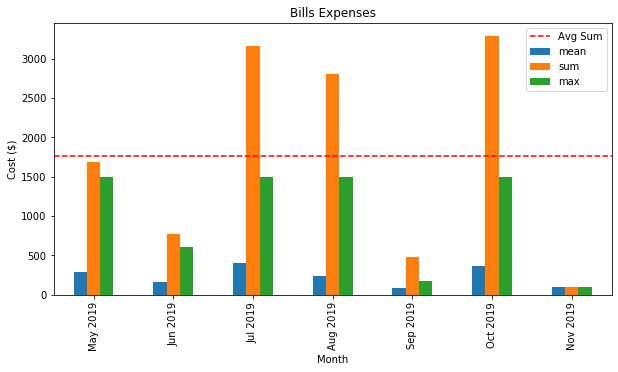

In [21]:
# Look at Bills for the past 6 months
y_bills = gb_m[(gb_m.index > six_months) & (gb_m['Category2'] == 'Bills')]
# Set Date format for x-axis ticks
y_bills.index = y_bills.index.strftime("%b %Y")
# Plot data
ax_bills = y_bills.plot.bar()
# Plot Average line
plt.axhline(y=y_bills['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_bills.legend()
ax_bills.set_xlabel('Month')
ax_bills.set_ylabel('Cost ($)')
ax_bills.set_title('Bills Expenses')

Text(0.5, 1.0, 'Bills Expenses')

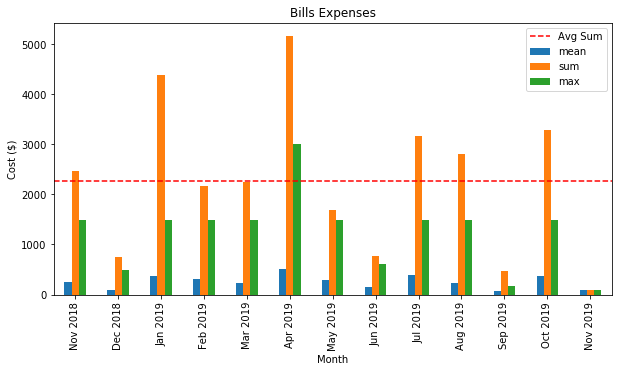

In [22]:
# Look at Bills for the past year
y_bills = gb_m[(gb_m.index > last_year) & (gb_m['Category2'] == 'Bills')]
# Set Date format for x-axis ticks
y_bills.index = y_bills.index.strftime("%b %Y")
# Plot data
ax_bills = y_bills.plot.bar()
# Plot Average line
plt.axhline(y=y_bills['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_bills.legend()
ax_bills.set_xlabel('Month')
ax_bills.set_ylabel('Cost ($)')
ax_bills.set_title('Bills Expenses')

Text(0.5, 1.0, 'Bills Expenses')

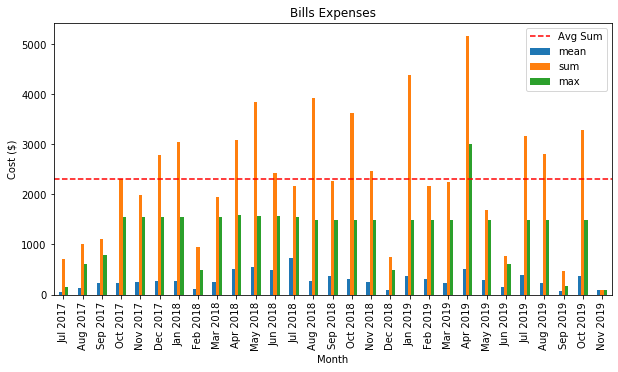

In [23]:
# Look at Bills since starting work
y_bills = gb_m[gb_m['Category2'] == 'Bills']
# Set Date format for x-axis ticks
y_bills.index = y_bills.index.strftime("%b %Y")
# Plot data
ax_bills = y_bills.plot.bar()
# Plot Average line
plt.axhline(y=y_bills['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_bills.legend()
ax_bills.set_xlabel('Month')
ax_bills.set_ylabel('Cost ($)')
ax_bills.set_title('Bills Expenses')

In [24]:
# y_bills['sum'].mean()

# Food

Text(0.5, 1.0, 'Food Expenses')

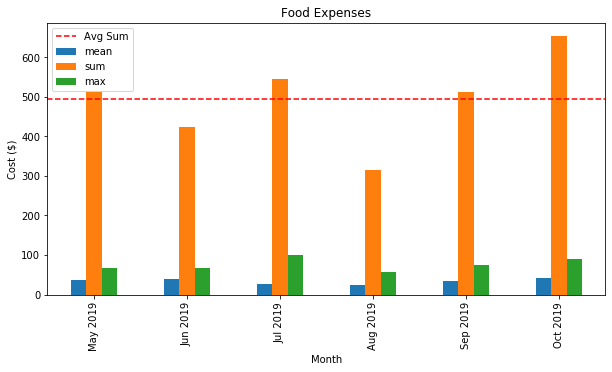

In [25]:
# Look at Food for the past 6 months
y_food = gb_m[(gb_m.index > six_months) & (gb_m['Category2'] == 'Food')]
# Set Date format for x-axis ticks
y_food.index = y_food.index.strftime("%b %Y")
# Plot data
ax_food = y_food.plot.bar()
# Plot Average line
plt.axhline(y=y_food['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_food.legend()
ax_food.set_xlabel('Month')
ax_food.set_ylabel('Cost ($)')
ax_food.set_title('Food Expenses')

Text(0.5, 1.0, 'Food Expenses')

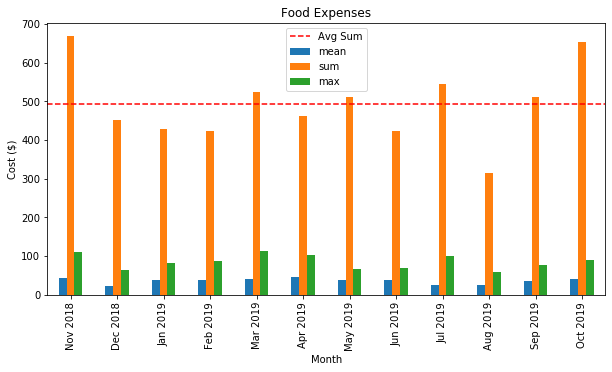

In [26]:
# Look at Food for the past year
y_food = gb_m[(gb_m.index > last_year) & (gb_m['Category2'] == 'Food')]
# Set Date format for x-axis ticks
y_food.index = y_food.index.strftime("%b %Y")
# Plot data
ax_food = y_food.plot.bar()
# Plot Average line
plt.axhline(y=y_food['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_food.legend()
ax_food.set_xlabel('Month')
ax_food.set_ylabel('Cost ($)')
ax_food.set_title('Food Expenses')

Text(0.5, 1.0, 'Food Expenses')

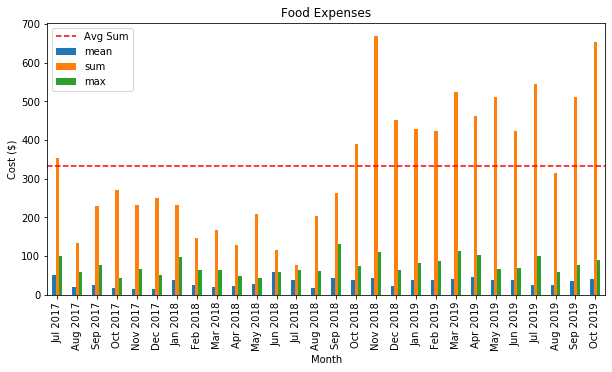

In [27]:
# Look at Food since starting work
y_food = gb_m[gb_m['Category2'] == 'Food']
# Set Date format for x-axis ticks
y_food.index = y_food.index.strftime("%b %Y")
# Plot data
ax_food = y_food.plot.bar()
# Plot Average line
plt.axhline(y=y_food['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_food.legend()
ax_food.set_xlabel('Month')
ax_food.set_ylabel('Cost ($)')
ax_food.set_title('Food Expenses')

# Shopping

Text(0.5, 1.0, 'Shopping Expenses')

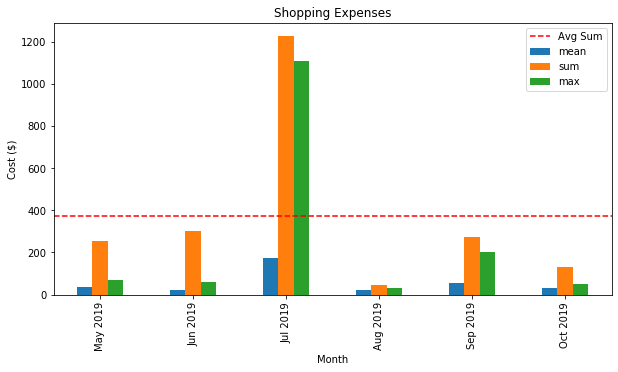

In [28]:
# Look at Shopping for the past 6 months
y_shopping = gb_m[(gb_m.index > six_months) & (gb_m['Category2'] == 'Shopping')]
# Set Date format for x-axis ticks
y_shopping.index = y_shopping.index.strftime("%b %Y")
# Plot data
ax_shopping = y_shopping.plot.bar()
# Plot Average line
plt.axhline(y=y_shopping['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_shopping.legend()
ax_shopping.set_xlabel('Month')
ax_shopping.set_ylabel('Cost ($)')
ax_shopping.set_title('Shopping Expenses')

Text(0.5, 1.0, 'Shopping Expenses')

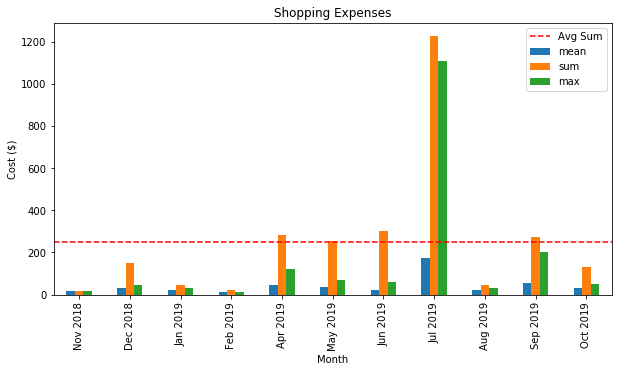

In [29]:
# Look at Shopping for the past year
y_shopping = gb_m[(gb_m.index > last_year) & (gb_m['Category2'] == 'Shopping')]
# Set Date format for x-axis ticks
y_shopping.index = y_shopping.index.strftime("%b %Y")
# Plot data
ax_shopping = y_shopping.plot.bar()
# Plot Average line
plt.axhline(y=y_shopping['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_shopping.legend()
ax_shopping.set_xlabel('Month')
ax_shopping.set_ylabel('Cost ($)')
ax_shopping.set_title('Shopping Expenses')

Text(0.5, 1.0, 'Shopping Expenses')

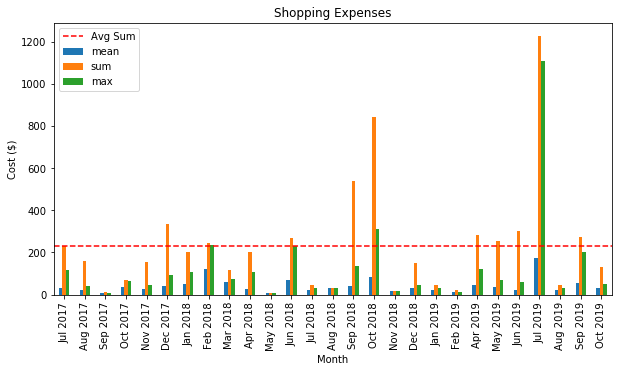

In [30]:
# Look at Shopping since starting working
y_shopping = gb_m[gb_m['Category2'] == 'Shopping']
# Set Date format for x-axis ticks
y_shopping.index = y_shopping.index.strftime("%b %Y")
# Plot data
ax_shopping = y_shopping.plot.bar()
# Plot Average line
plt.axhline(y=y_shopping['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_shopping.legend()
ax_shopping.set_xlabel('Month')
ax_shopping.set_ylabel('Cost ($)')
ax_shopping.set_title('Shopping Expenses')

# Fun

Text(0.5, 1.0, 'Fun Expenses')

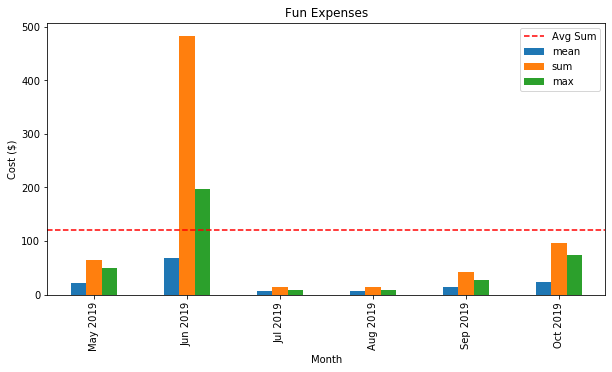

In [31]:
# Look at Fun for the past 6 months
y_fun = gb_m[(gb_m.index > six_months) & (gb_m['Category2'] == 'Fun')]
# Set Date format for x-axis ticks
y_fun.index = y_fun.index.strftime("%b %Y")
# Plot data
ax_fun = y_fun.plot.bar()
# Plot Average line
plt.axhline(y=y_fun['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_fun.legend()
ax_fun.set_xlabel('Month')
ax_fun.set_ylabel('Cost ($)')
ax_fun.set_title('Fun Expenses')

Text(0.5, 1.0, 'Fun Expenses')

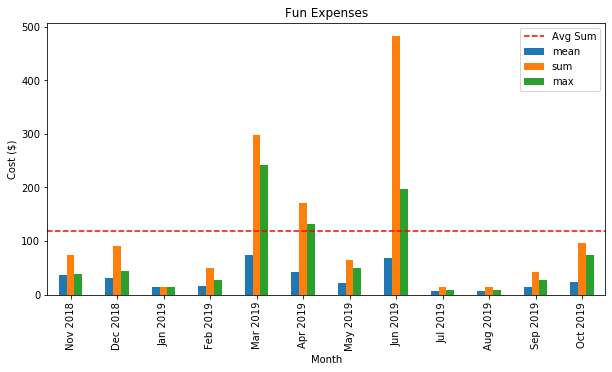

In [32]:
# Look at Fun for the past year
y_fun = gb_m[(gb_m.index > last_year) & (gb_m['Category2'] == 'Fun')]
# Set Date format for x-axis ticks
y_fun.index = y_fun.index.strftime("%b %Y")
# Plot data
ax_fun = y_fun.plot.bar()
# Plot Average line
plt.axhline(y=y_fun['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_fun.legend()
ax_fun.set_xlabel('Month')
ax_fun.set_ylabel('Cost ($)')
ax_fun.set_title('Fun Expenses')

Text(0.5, 1.0, 'Fun Expenses')

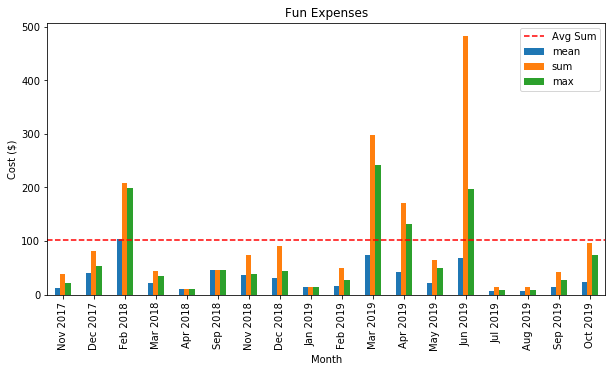

In [33]:
# Look at Fun since starting working 
y_fun = gb_m[gb_m['Category2'] == 'Fun']
# Set Date format for x-axis ticks
y_fun.index = y_fun.index.strftime("%b %Y")
# Plot data
ax_fun = y_fun.plot.bar()
# Plot Average line
plt.axhline(y=y_fun['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_fun.legend()
ax_fun.set_xlabel('Month')
ax_fun.set_ylabel('Cost ($)')
ax_fun.set_title('Fun Expenses')

# Travel

Text(0.5, 1.0, 'Travel Expenses')

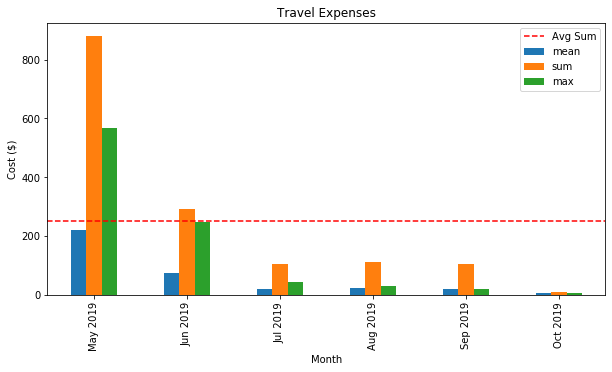

In [34]:
# Look at Travel for past 6 months
y_travel = gb_m[(gb_m.index > six_months) & (gb_m['Category2'] == 'Travel')]
# Set Date format for x-axis ticks
y_travel.index = y_travel.index.strftime("%b %Y")
# Plot data
ax_travel = y_travel.plot.bar()
# Plot Average line
plt.axhline(y=y_travel['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_travel.legend()
ax_travel.set_xlabel('Month')
ax_travel.set_ylabel('Cost ($)')
ax_travel.set_title('Travel Expenses')

Text(0.5, 1.0, 'Travel Expenses')

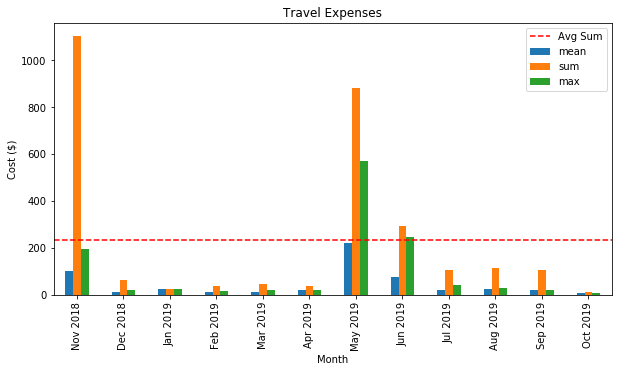

In [35]:
# Look at Travel for past year
y_travel = gb_m[(gb_m.index > last_year) & (gb_m['Category2'] == 'Travel')]
# Set Date format for x-axis ticks
y_travel.index = y_travel.index.strftime("%b %Y")
# Plot data
ax_travel = y_travel.plot.bar()
# Plot Average line
plt.axhline(y=y_travel['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_travel.legend()
ax_travel.set_xlabel('Month')
ax_travel.set_ylabel('Cost ($)')
ax_travel.set_title('Travel Expenses')

Text(0.5, 1.0, 'Travel Expenses')

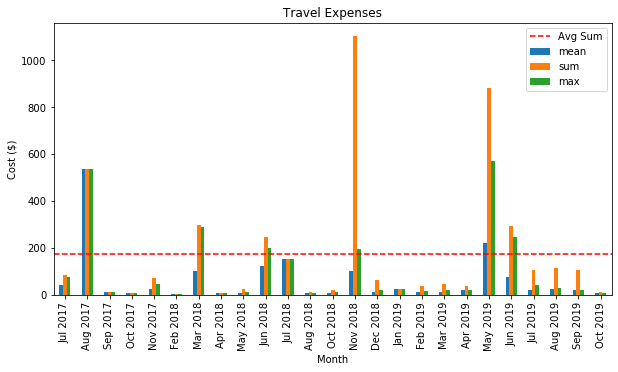

In [36]:
# Look at Travel since starting work
y_travel = gb_m[gb_m['Category2'] == 'Travel']
# Set Date format for x-axis ticks
y_travel.index = y_travel.index.strftime("%b %Y")
# Plot data
ax_travel = y_travel.plot.bar()
# Plot Average line
plt.axhline(y=y_travel['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_travel.legend()
ax_travel.set_xlabel('Month')
ax_travel.set_ylabel('Cost ($)')
ax_travel.set_title('Travel Expenses')

# Misc

Text(0.5, 1.0, 'Misc Expenses')

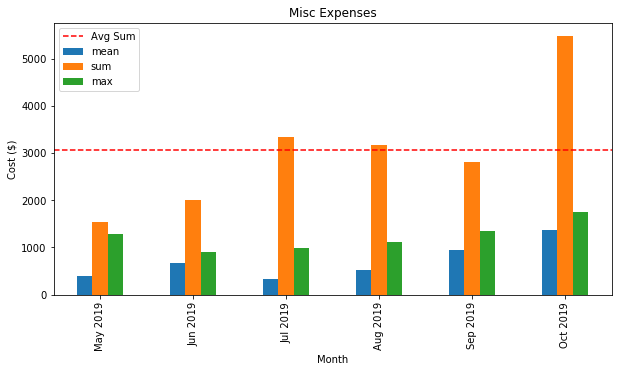

In [37]:
# Look at Misc for past 6 months
y_misc = gb_m[(gb_m.index > six_months) & (gb_m['Category2'] == 'Misc')]
# Set Date format for x-axis ticks
y_misc.index = y_misc.index.strftime("%b %Y")
# Plot data
ax_misc = y_misc.plot.bar()
# Plot Average line
plt.axhline(y=y_misc['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_misc.legend()
ax_misc.set_xlabel('Month')
ax_misc.set_ylabel('Cost ($)')
ax_misc.set_title('Misc Expenses')

Text(0.5, 1.0, 'Misc Expenses')

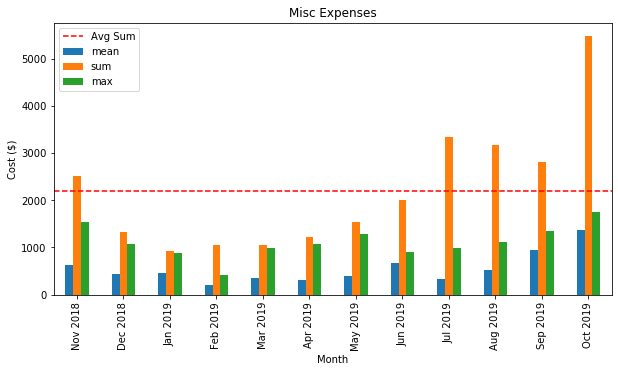

In [38]:
# Look at Misc for past year
y_misc = gb_m[(gb_m.index > last_year) & (gb_m['Category2'] == 'Misc')]
# Set Date format for x-axis ticks
y_misc.index = y_misc.index.strftime("%b %Y")
# Plot data
ax_misc = y_misc.plot.bar()
# Plot Average line
plt.axhline(y=y_misc['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_misc.legend()
ax_misc.set_xlabel('Month')
ax_misc.set_ylabel('Cost ($)')
ax_misc.set_title('Misc Expenses')

Text(0.5, 1.0, 'Misc Expenses')

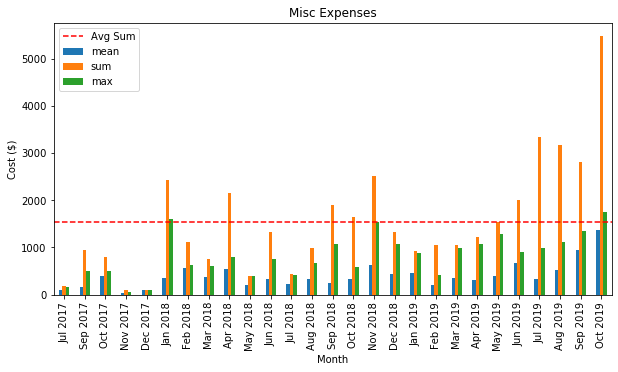

In [39]:
# Look at Misc since starting work
y_misc = gb_m[gb_m['Category2'] == 'Misc']
# Set Date format for x-axis ticks
y_misc.index = y_misc.index.strftime("%b %Y")
# Plot data
ax_misc = y_misc.plot.bar()
# Plot Average line
plt.axhline(y=y_misc['sum'].mean(), linestyle='--', color='r', label='Avg Sum')
# Set rest of plot settings
ax_misc.legend()
ax_misc.set_xlabel('Month')
ax_misc.set_ylabel('Cost ($)')
ax_misc.set_title('Misc Expenses')

# Net Income

In [40]:
# Calculate Net Income
gb_mnet = core[core.index > job_start_date].groupby([pd.Grouper(freq='M'), 'Transaction Type'])['Amount'].sum()
gb_mnet = gb_mnet.unstack(level=1)
gb_mnet['Net'] = gb_mnet['credit'] - gb_mnet['debit']
gb_mnet.head(n=15)

Transaction Type,credit,debit,Net
Date,,,
2017-07-31,4418.79,1569.75,2849.04
2017-08-31,4184.71,1838.13,2346.58
2017-09-30,4621.85,2205.07,2416.78
2017-10-31,5237.66,3456.08,1781.58
2017-11-30,5160.33,2579.65,2580.68
2017-12-31,8143.06,3552.99,4590.07
2018-01-31,4950.24,5228.44,-278.20
2018-02-28,8567.59,1557.10,7010.49
2018-03-31,7609.68,2727.30,4882.38


Text(0.5, 1.0, 'Net Income Per Month')

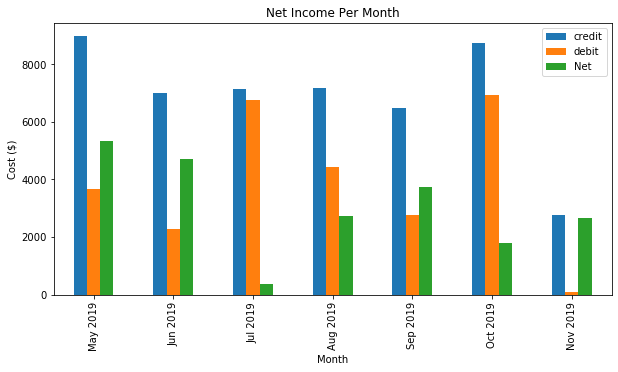

In [41]:
# Look at Net Income for past 6 months
mnet = gb_mnet[(gb_mnet.index > six_months)]
# Set Date format for x-axis ticks
mnet.index = mnet.index.strftime("%b %Y")
# Plot Data
ax_mnet = mnet.plot.bar()
# Set rest of plot settings
ax_mnet.legend()
ax_mnet.set_xlabel('Month')
ax_mnet.set_ylabel('Cost ($)')
ax_mnet.set_title('Net Income Per Month')

Text(0.5, 1.0, 'Net Income Per Month')

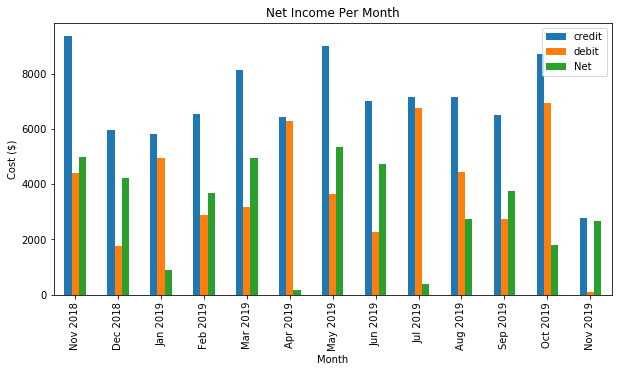

In [42]:
# Look at Net Income for past year
mnet = gb_mnet[(gb_mnet.index > last_year)]
# Set Date format for x-axis ticks
mnet.index = mnet.index.strftime("%b %Y")
# Plot Data
ax_mnet = mnet.plot.bar()
# Set rest of plot settings
ax_mnet.legend()
ax_mnet.set_xlabel('Month')
ax_mnet.set_ylabel('Cost ($)')
ax_mnet.set_title('Net Income Per Month')

Text(0.5, 1.0, 'Net Income Per Month')

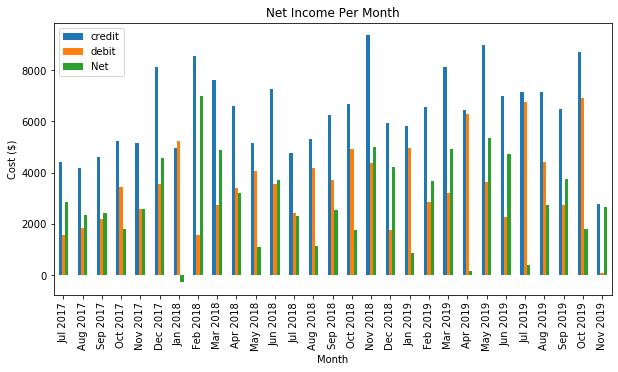

In [43]:
# Look at Net Income since starting working
mnet = gb_mnet
# Set Date format for x-axis ticks
mnet.index = mnet.index.strftime("%b %Y")
# Plot Data
ax_mnet = mnet.plot.bar()
# Set rest of plot settings
ax_mnet.legend()
ax_mnet.set_xlabel('Month')
ax_mnet.set_ylabel('Cost ($)')
ax_mnet.set_title('Net Income Per Month')

# Income

C:\Users\xrchr\Miniconda3\envs\minimal_ds\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017C69737BE0>,
      dtype=object)

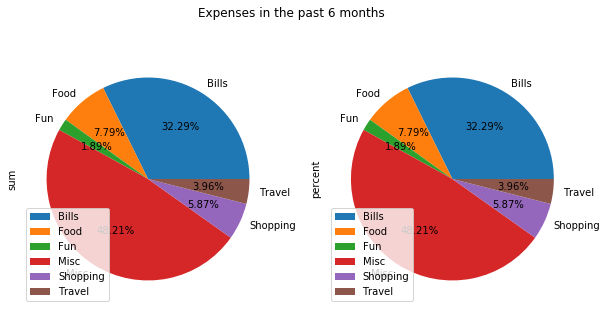

In [44]:
tot_inc = gb_m[(gb_m.index > six_months) & (gb_m['Category2'] == 'Income')]['sum'].sum()
pie_chart = gb_m[(gb_m.index > six_months) & (~gb_m['Category2'].str.contains('Income'))]
pie_chart['percent'] = pie_chart['sum']/tot_inc
pie_chart = pie_chart.groupby('Category2')['sum', 'percent'].sum()
# pie_chart = gb_m[(gb_m.index > six_months) & (gb_m['Category2'] != 'Income')].groupby('Category2')['sum'].sum()
title = 'Expenses in the past 6 months'
pie_chart.plot.pie(autopct='%1.2f%%', subplots=True, title=title)

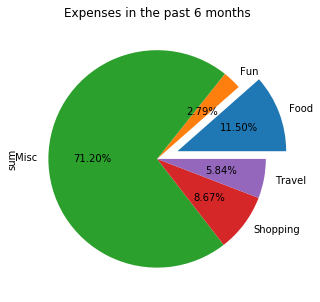

In [45]:
pie_chart = gb_m[(gb_m.index > six_months) & (~gb_m['Category2'].str.contains('Income|Bills'))].groupby('Category2')[
    'sum'].sum()
title = 'Expenses in the past 6 months'
pie_chart.plot.pie(autopct='%1.2f%%', explode=(0.2, 0, 0, 0, 0), title=title)

C:\Users\xrchr\Miniconda3\envs\minimal_ds\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017C6983BEF0>,
      dtype=object)

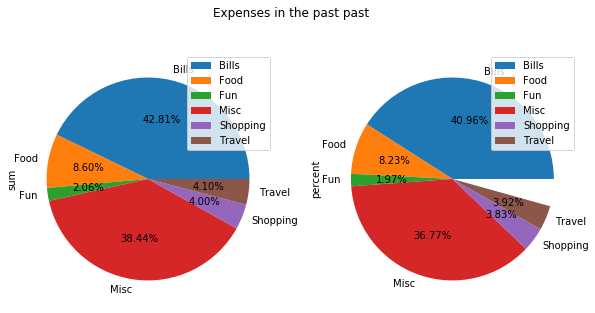

In [46]:
tot_inc = gb_m[(gb_m.index > last_year) & (gb_m['Category2'] == 'Income')]['sum'].sum()
pie_chart = gb_m[(gb_m.index > last_year) & (~gb_m['Category2'].str.contains('Income'))]
pie_chart['percent'] = pie_chart['sum']/tot_inc
pie_chart = pie_chart.groupby('Category2')['sum', 'percent'].sum()
# pie_chart = gb_m[(gb_m.index > last_year) & (gb_m['Category2'] != 'Income')].groupby('Category2')['sum'].sum()
title = 'Expenses in the past past'
pie_chart.plot.pie(autopct='%1.2f%%', subplots=True, title=title)

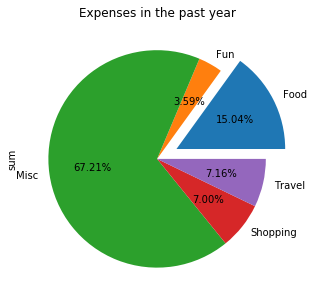

In [47]:
pie_chart = gb_m[(gb_m.index > last_year) & (~gb_m['Category2'].str.contains('Income|Bills'))].groupby('Category2')[
    'sum'].sum()
title = 'Expenses in the past year'
pie_chart.plot.pie(autopct='%1.2f%%', explode=(0.2, 0, 0, 0, 0), title=title)

C:\Users\xrchr\Miniconda3\envs\minimal_ds\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017C69977128>,
      dtype=object)

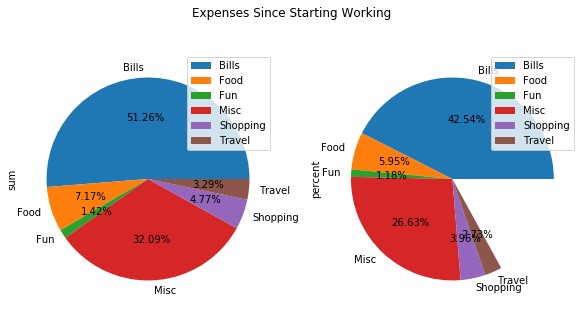

In [48]:
tot_inc = gb_m[(gb_m['Category2'] == 'Income')]['sum'].sum()
pie_chart = gb_m[(~gb_m['Category2'].str.contains('Income'))]
pie_chart['percent'] = pie_chart['sum']/tot_inc
pie_chart = pie_chart.groupby('Category2')['sum', 'percent'].sum()
# pie_chart = gb_m[(gb_m['Category2'] != 'Income')].groupby('Category2')['sum'].sum()
title = 'Expenses Since Starting Working'
pie_chart.plot.pie(autopct='%1.2f%%', subplots=True, title=title)

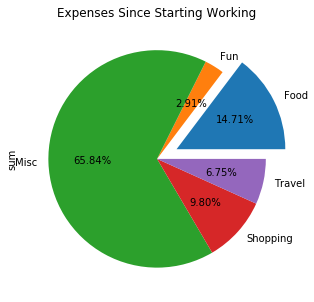

In [49]:
pie_chart = gb_m[(~gb_m['Category2'].str.contains('Income|Bills'))].groupby('Category2')[
    'sum'].sum()
title = 'Expenses Since Starting Working'
pie_chart.plot.pie(autopct='%1.2f%%', explode=(0.2, 0, 0, 0, 0), title=title)

# Last Month Breakdown

Text(0.5, 1.0, 'Summary of Last Months SPending')

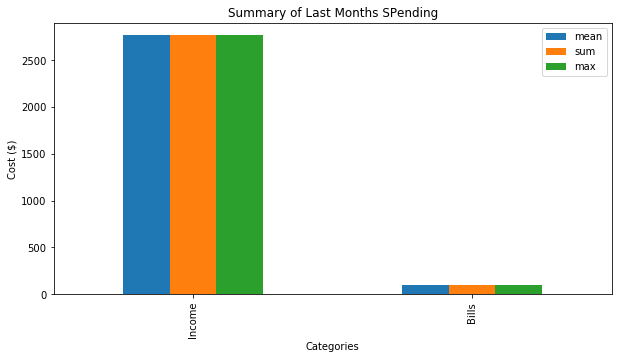

In [50]:
# now_snap = gb_m[(gb_m.index > last_month) & (gb_m['Category2'] != 'Income')]
now_snap = gb_m[(gb_m.index > last_month)]
ax_now = now_snap.plot.bar()
ax_now.set_xticklabels(now_snap['Category2'])
ax_now.set_xlabel('Categories')
ax_now.set_ylabel('Cost ($)')
ax_now.set_title('Summary of Last Months SPending')
# gb_m.index

C:\Users\xrchr\Miniconda3\envs\minimal_ds\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017C69B16DA0>,
      dtype=object)

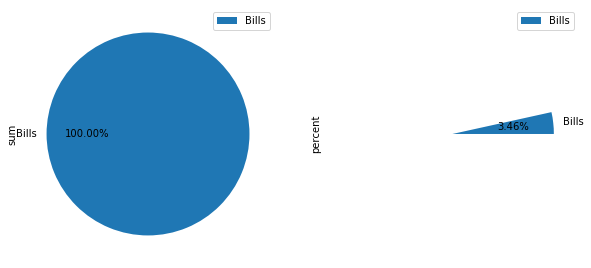

In [51]:
tot_inc = gb_m[(gb_m.index > last_month) & (gb_m['Category2'] == 'Income')]['sum'].sum()
pie_chart = gb_m[(gb_m.index > last_month) & (~gb_m['Category2'].str.contains('Income'))]
pie_chart['percent'] = pie_chart['sum']/tot_inc
pie_chart = pie_chart.groupby('Category2')['sum', 'percent'].sum()
pie_chart.plot.pie(autopct='%1.2f%%', subplots=True)

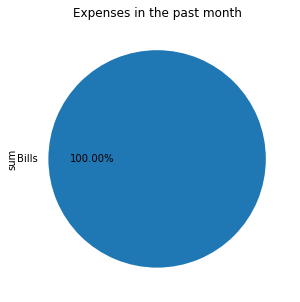

In [52]:
pie_chart = gb_m[(gb_m.index > last_month) & (~gb_m['Category2'].str.contains('Income'))].groupby('Category2')[
    'sum'].sum()
title = 'Expenses in the past month'
pie_chart.plot.pie(autopct='%1.2f%%', title=title)

In [53]:
# Lets take a look at the past few months
gb_month2 = core[core.index > job_start_date].groupby([pd.Grouper(freq='M'), 'Category'])['Amount'].\
    agg(['mean', 'sum', 'max']).sort_values(by=['Date', 'sum'], ascending=[True, False])
gb_month2.head(n=15)

mean      sum      max
Date       Category                                          
2017-07-31 Paycheck             2059.395000  4118.79  2118.79
           Mortgage & Rent       151.150000   453.45   151.15
           Income                150.000000   300.00   200.00
           Groceries              85.440000   256.32   100.18
           Shopping               62.006667   186.02   115.25
           Credit Card Payment   151.150000   151.15   151.15
           Gas & Fuel             17.680000   123.76    31.65
           Restaurants            24.327500    97.31    40.72
           Service & Parts        84.940000    84.94    84.94
           Hotel                  76.380000    76.38    76.38
           Utilities              51.200000    51.20    51.20
           Home Services          38.860000    38.86    38.86
           Business Services      16.000000    16.00    16.00
           Clothing                7.630000    15.26    10.90
           Pharmacy               13.100000    13.10    13.10

In [54]:
# gb_m2 = gb_month2.reset_index(level='Category')
# gb_m2 = gb_m2[(gb_m2.index > last_month) & gb_month['Category'].str.contians("|".join(Bills))]
gb_m2 = gb_month2.reset_index(level='Category')
gb_m2.head()

,Category,mean,sum,max
Date,,,,
2017-07-31,Paycheck,2059.395000,4118.79,2118.79
2017-07-31,Mortgage & Rent,151.150000,453.45,151.15
2017-07-31,Income,150.000000,300.00,200.00
2017-07-31,Groceries,85.440000,256.32,100.18
2017-07-31,Shopping,62.006667,186.02,115.25


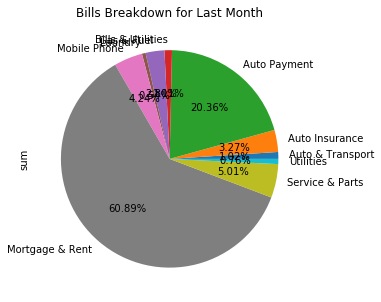

In [55]:
now_bills = gb_m2[(gb_m2.index > "2019-02") & (gb_m2['Category'].str.contains("|".join(Bills)))]
now_bills = now_bills.groupby('Category')['sum'].sum()
title = "Bills Breakdown for Last Month"
now_bills.plot.pie(autopct='%1.2f%%', title=title)
# ax.set_xticklabels(now_bills['Category'])

In [56]:
now_food = gb_m2[(gb_m2.index > last_month) & (gb_m2['Category'].str.contains("|".join(Food)))]
# now_food = now_food.groupby('Category')['sum'].sum()
# title = "Food Breakdown for Last Month"
# now_food.plot.pie(autopct='%1.2f%%', title=title)

In [57]:
now_fun = gb_m2[(gb_m2.index > last_month) & (gb_m2['Category'].str.contains("|".join(Fun)))]
now_fun = now_fun.groupby('Category')['sum'].sum()
title = "Fun Breakdown for Last Month"
now_fun.plot.pie(autopct='%1.2f%%', title=title)

TypeError: no numeric data to plot

In [ ]:
now_travel = gb_m2[(gb_m2.index > last_month) & (gb_m2['Category'].str.contains("|".join(Travel)))]
now_travel = now_travel.groupby('Category')['sum'].sum()
title = "Travel Breakdown for Last Month"
now_travel.plot.pie(autopct='%1.2f%%', title=title)

In [ ]:
now_shopping = gb_m2[(gb_m2.index > last_month) & (gb_m2['Category'].str.contains("|".join(Shopping)))]
now_shopping = now_shopping.groupby('Category')['sum'].sum()
title = "Shopping Breakdown for Last Month"
now_shopping.plot.pie(autopct='%1.2f%%', title=title)

In [ ]:
ax_nowNet = gb_mnet[gb_mnet.index > last_month].plot.bar()
ax_nowNet.set_title('Net Income for the last month')
ax_nowNet.set_xlabel('Month')
ax_nowNet.set_ylabel('Cost ($)')

In [ ]:
dayNet = core[core.index > '2019-01-31'].groupby([pd.Grouper(freq='D'), 'Transaction Type'])['Amount'].sum().unstack(level=1)
dayNet.index = dayNet.index.strftime("%d %a")
dayNet['Net'] = dayNet['credit'] - dayNet['debit']
ax_dayNet = dayNet.plot.bar()
ax_dayNet.set_title('Net Income per day for the last month')
ax_dayNet.set_xlabel('Day')
ax_dayNet.set_ylabel('Cost ($)')

In [ ]:
#########################################################################################################
# Old code #
#########################################################################################################

In [ ]:
core['Description'].unique()

In [ ]:
# Grocery List for the month
month1 = core[core.index > movein_date].groupby('Description')['Description', 'Freq-Desc'].\
    agg({'Description': 'count', 'Freq-Desc': 'mean'}).rename(
    columns={'Description': 'Count', 'Freq-Desc': 'Days'})
month = month1.groupby('Description')['Count', 'Days'].mean().sort_values(by='Days', ascending=True)
month['Count'] = month['Count'].round()

month.head(n=15)

In [ ]:
# month_list = month[(month['Days'] > 0) & (month['Days'] < 40)]
month_list = month[(month['Count'] > 5)]
month_list

In [ ]:
movein_date